Bin2Cell Cell Expansion 

In [29]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.sparse import load_npz, issparse
from skimage import io, measure
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors, cm
%matplotlib inline

In [31]:
def tile_gene_b2c_expand(ctx, tile,
                         gene=None,
                         obs_col=None,
                         category=None,
                         color_mode="gradient",
                         expr_quantile=None,
                         top_n=None,
                         render_mode="outline",      # "outline" | "fill"
                         # expansion params
                         b2c_mode="fixed",
                         max_bin_distance=2,
                         mpp=0.3,
                         bin_um=2.0,
                         volume_ratio=4.0,
                         all_expanded_outline=True,
                         expanded_edges_color="lightgray",
                         expanded_edges_alpha=0.7,
                         expanded_edges_width=0.6,
                         all_nuclei_outline=False,
                         nuclei_edges_color="lightgray",
                         nuclei_edges_alpha=0.7,
                         nuclei_edges_width=0.6,
                         highlight_color="lime",
                         highlight_width=2.5,
                         cmap_name="viridis",
                         vmin=None, vmax=None,
                         custom_title=None,
                         overlay_alpha=0.5,      # NEW: overlay opacity
                         he_alpha=1.0,           # NEW: H&E opacity
                         legend_outside=True,    # NEW: place legend outside
                         show_centroids=False):

    import numpy as np, pandas as pd, matplotlib.pyplot as plt
    from matplotlib import colors, cm
    from matplotlib.collections import LineCollection
    from matplotlib.patches import Patch
    from skimage.segmentation import find_boundaries
    from skimage import measure

    # Expanded labels + raw labels for outlines
    he, lab_exp, dist_px = expand_labels_b2c_tile(
        ctx, tile, mode=b2c_mode, max_bin_distance=max_bin_distance,
        mpp=mpp, bin_um=bin_um, volume_ratio=volume_ratio
    )
    r0,r1,c0,c1 = tile["r0"], tile["r1"], tile["c0"], tile["c1"]
    _, lab_raw = ctx.crop_rc(r0, r1, c0, c1)

    # OBS-COLUMN OVERLAY (your current use)
    if obs_col is not None:
        in_tile = (ctx.rows >= r0) & (ctx.rows < r1) & (ctx.cols >= c0) & (ctx.cols < c1)
        if not np.any(in_tile):
            raise RuntimeError("No centroids in this tile.")

        rr = (ctx.rows[in_tile] - r0).astype(int)
        cc = (ctx.cols[in_tile] - c0).astype(int)
        lbls = lab_exp[rr, cc]

        if obs_col not in ctx.adata.obs.columns:
            raise KeyError(f"'{obs_col}' not found in adata.obs.")

        vals = ctx.adata.obs.loc[in_tile, obs_col].to_numpy()

        # Majority category per expanded label
        from collections import Counter, defaultdict
        counts = defaultdict(Counter)
        for lbl, val in zip(lbls, vals):
            if lbl <= 0: continue
            key = "" if pd.isna(val) else str(val)
            counts[lbl][key] += 1
        label_to_cat = {lbl: cnts.most_common(1)[0][0] for lbl, cnts in counts.items() if cnts}

        fig, ax = plt.subplots(figsize=(8,8), constrained_layout=False)
        ax.imshow(he, zorder=0, alpha=he_alpha)  # USE he_alpha

        if all_nuclei_outline:
            e_raw = find_boundaries(lab_raw, mode="inner")
            ax.contour(e_raw, levels=[0.5], colors=nuclei_edges_color,
                       linewidths=nuclei_edges_width, alpha=nuclei_edges_alpha, zorder=1)
        if all_expanded_outline:
            e_exp = find_boundaries(lab_exp, mode="inner")
            ax.contour(e_exp, levels=[0.5], colors=expanded_edges_color,
                       linewidths=expanded_edges_width, alpha=expanded_edges_alpha, zorder=2)

        if category is None:
            # Show all categories with discrete colors
            cats = sorted(set(label_to_cat.values()))
            from matplotlib.colors import ListedColormap
            base = cm.get_cmap("tab20")
            cat_to_idx = {c:i for i,c in enumerate(cats)}
            lut = np.full(int(lab_exp.max())+1, -1, dtype=int)
            for lbl, cat in label_to_cat.items():
                lut[lbl] = cat_to_idx[cat]
            mask = lut[lab_exp]
            cmap = ListedColormap([base(i/max(1,len(cats)-1)) for i in range(len(cats))])

            ax.imshow(mask, cmap=cmap, alpha=overlay_alpha,  # USE overlay_alpha
                      vmin=0, vmax=len(cats)-1, zorder=3)

            handles = [Patch(facecolor=cmap(cat_to_idx[c]), edgecolor="none", label=c) for c in cats]
            if legend_outside:
                # Make room on the right and anchor legend outside
                fig.subplots_adjust(right=0.82)
                ax.legend(handles=handles, title=obs_col, loc="center left",
                          bbox_to_anchor=(1.02, 0.5), frameon=True, borderaxespad=0.)
            else:
                ax.legend(handles=handles, title=obs_col, loc="upper right", frameon=True)

            title_str = custom_title or f"Tile {tile['id']} — {obs_col} (majority per expanded label)"

        else:
            # Highlight one category
            target = str(category)
            keep = {lbl for lbl, cat in label_to_cat.items() if cat == target}
            if render_mode == "fill":
                from matplotlib.colors import ListedColormap
                lut = np.zeros(int(lab_exp.max())+1, dtype=int)
                for lbl in keep: lut[lbl] = 1
                cm_bin = ListedColormap([(0,0,0,0), colors.to_rgba(highlight_color)])
                ax.imshow(lut[lab_exp].astype(float), cmap=cm_bin,
                          alpha=overlay_alpha, zorder=3)  # USE overlay_alpha
            else:
                lines = []
                for lbl in keep:
                    rr_lbl, cc_lbl = np.where(lab_exp == lbl)
                    if rr_lbl.size == 0: continue
                    rmin, rmax = rr_lbl.min(), rr_lbl.max()+1
                    cmin, cmax = cc_lbl.min(), cc_lbl.max()+1
                    roi = (lab_exp[rmin:rmax, cmin:cmax] == lbl)
                    for c in measure.find_contours(roi, 0.5):
                        c[:,0] += rmin; c[:,1] += cmin
                        lines.append(np.column_stack((c[:,1], c[:,0])))
                if lines:
                    ax.add_collection(LineCollection(lines, colors=highlight_color,
                                                     linewidths=highlight_width, zorder=4))
            title_str = custom_title or f"Tile {tile['id']} — {obs_col} == {target}"

        ax.set_title(title_str)
        ax.set_xticks([]); ax.set_yticks([])
        plt.tight_layout()
        plt.show()
        return

    # GENE OVERLAY (unchanged logic; now with he_alpha/overlay_alpha)
    from scipy.sparse import issparse
    if gene is None:
        raise ValueError("Provide either gene or obs_col.")
    if gene not in ctx.adata.var_names:
        raise ValueError(f"{gene} not in adata.var_names.")

    Xg = ctx.adata[:, gene].X
    if issparse(Xg): Xg = Xg.toarray()
    Xg = np.asarray(Xg).ravel()

    in_tile = (ctx.rows >= r0) & (ctx.rows < r1) & (ctx.cols >= c0) & (ctx.cols < c1)
    if not np.any(in_tile):
        raise RuntimeError("No centroids in this tile.")

    thr = None
    keep = in_tile.copy()
    if expr_quantile is not None:
        thr = np.quantile(Xg[in_tile], expr_quantile)
        keep &= (Xg > thr)

    rows_k = ctx.rows[keep] - r0
    cols_k = ctx.cols[keep] - c0
    vals_k = Xg[keep]

    lab_expr = {}
    Ht, Wt = lab_exp.shape
    for rr, cc, v in zip(rows_k, cols_k, vals_k):
        if 0 <= rr < Ht and 0 <= cc < Wt:
            lbl = lab_exp[rr, cc]
            if lbl > 0 and ((lbl not in lab_expr) or (v > lab_expr[lbl])):
                lab_expr[lbl] = v

    keep_labels = np.array(sorted(lab_expr.keys()), dtype=int)
    if keep_labels.size == 0:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.imshow(he, zorder=0, alpha=he_alpha)   # USE he_alpha
        ax.set_title(f"Tile {tile['id']} — {gene}: 0 expanded labels pass"
                     + (f" (q={expr_quantile:.2f}, thr≈{thr:.3g})" if thr is not None else ""))
        ax.set_xticks([]); ax.set_yticks([])
        plt.tight_layout(); plt.show()
        return

    if color_mode == "gradient":
        vals = np.array([lab_expr[l] for l in keep_labels], dtype=float)
        if vmin is None or vmax is None:
            if vals.size > 5:
                vmin, vmax = np.percentile(vals, [2, 98])
            else:
                vmin, vmax = float(vals.min()), float(vals.max())
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = cm.get_cmap(cmap_name)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(he, zorder=0, alpha=he_alpha)       # USE he_alpha

    if all_nuclei_outline:
        e_raw = find_boundaries(lab_raw, mode="inner")
        ax.contour(e_raw, levels=[0.5], colors=nuclei_edges_color,
                   linewidths=nuclei_edges_width, alpha=nuclei_edges_alpha, zorder=1)
    if all_expanded_outline:
        e_exp = find_boundaries(lab_exp, mode="inner")
        ax.contour(e_exp, levels=[0.5], colors=expanded_edges_color,
                   linewidths=expanded_edges_width, alpha=expanded_edges_alpha, zorder=2)

    if render_mode == "fill":
        if color_mode == "binary":
            from matplotlib.colors import ListedColormap
            cm_bin = ListedColormap([(0,0,0,0), (0,1,0,1)])
            lut = np.full(int(lab_exp.max())+1, np.nan, dtype=float)
            for lbl in keep_labels: lut[lbl] = 1.0
            mask = ~np.isnan(lut[lab_exp])
            ax.imshow(mask.astype(float), cmap=cm_bin, alpha=overlay_alpha, zorder=3)  # USE overlay_alpha
        else:
            lut = np.full(int(lab_exp.max())+1, np.nan, dtype=float)
            for lbl in keep_labels: lut[lbl] = lab_expr[lbl]
            im = ax.imshow(lut[lab_exp], cmap=cmap, norm=norm, alpha=overlay_alpha, zorder=3)  # USE overlay_alpha
            cb = plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02)
            cb.set_label(f"{gene} (max per expanded label)")
    else:
        if color_mode == "binary":
            lines = []
            for lbl in keep_labels:
                rr, cc = np.where(lab_exp == lbl)
                if rr.size == 0: continue
                rmin, rmax = rr.min(), rr.max()+1
                cmin, cmax = cc.min(), cc.max()+1
                roi = (lab_exp[rmin:rmax, cmin:cmax] == lbl)
                for c in measure.find_contours(roi, 0.5):
                    c[:,0] += rmin; c[:,1] += cmin
                    lines.append(np.column_stack((c[:,1], c[:,0])))
            if lines:
                ax.add_collection(LineCollection(lines, colors=highlight_color,
                                                 linewidths=highlight_width, zorder=4))
        else:
            lines, line_colors = [], []
            norm = colors.Normalize(vmin=vmin, vmax=vmax)
            for lbl in keep_labels:
                rr, cc = np.where(lab_exp == lbl)
                if rr.size == 0: continue
                rmin, rmax = rr.min(), rr.max()+1
                cmin, cmax = cc.min(), cc.max()+1
                roi = (lab_exp[rmin:rmax, cmin:cmax] == lbl)
                for c in measure.find_contours(roi, 0.5):
                    c[:,0] += rmin; c[:,1] += cmin
                    lines.append(np.column_stack((c[:,1], c[:,0])))
                    line_colors.append(cm.get_cmap(cmap_name)(norm(lab_expr[lbl])))
            if lines:
                ax.add_collection(LineCollection(lines, colors=line_colors,
                                                 linewidths=highlight_width, zorder=4))
            sm = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap(cmap_name)); sm.set_array([])
            cb = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
            cb.set_label(f"{gene} (max per expanded label)")

    title_str = custom_title or (
        f"Tile {tile['id']} — {gene} | expand={b2c_mode} "
        f"(max_bin_distance={max_bin_distance}, ~{dist_px}px) | color_mode={color_mode}"
        + (f" | q={expr_quantile:.2f}" if expr_quantile is not None else "")
    )
    ax.set_title(title_str)
    ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout(); plt.show()



Slide shape (H,W): (20852, 22785) | coords: obsm['spatial_cropped_150_buffer']


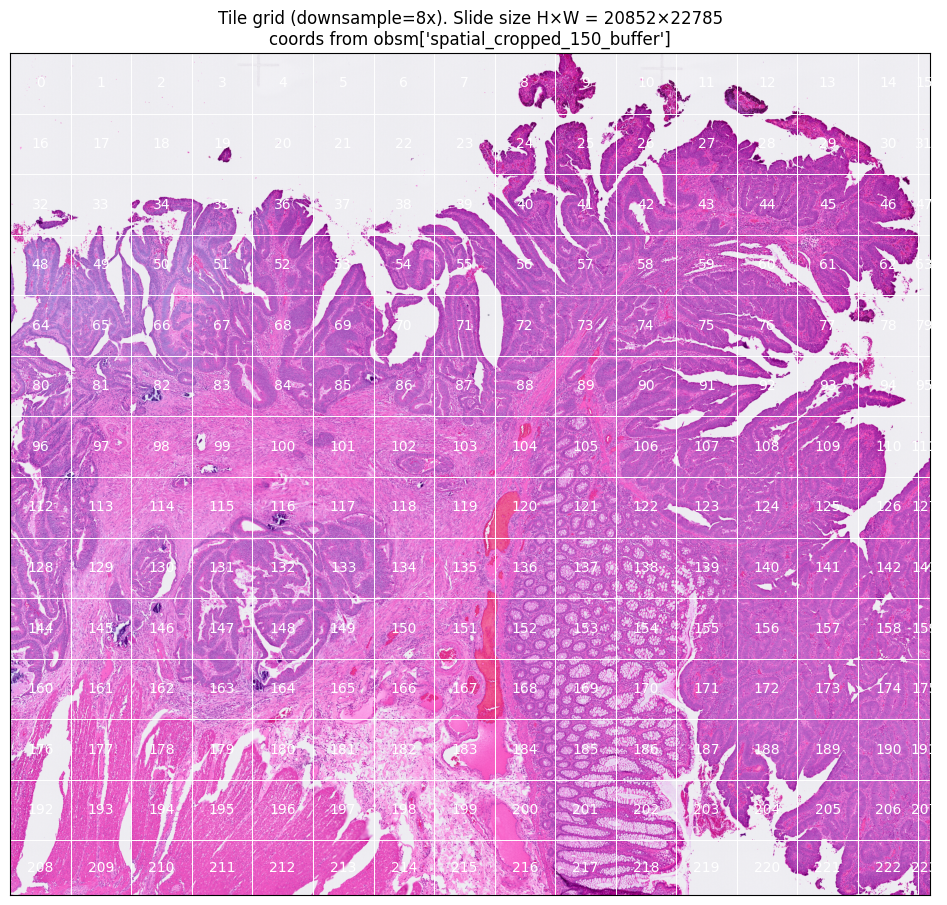

In [33]:
ctx = B2CContext(
    he_image_path   = "/gpfs/commons/groups/innovation/jjoseph/bin2cell_results/P2_CRC/stardist/he.tiff",
    labels_npz_path = "/gpfs/commons/groups/innovation/jjoseph/bin2cell_results/P2_CRC/stardist/he.npz",
    adata_path      = "/gpfs/commons/groups/innovation/share/10X_VisiumHD_CRC/adata/annotated_b2c_adatas/P2_CRC_annotated.h5ad",
)
print("Slide shape (H,W):", ctx.shape, "| coords:", ctx.coord_source)

tiles = make_tiles(ctx, tile_h=1500, tile_w=1500, stride_h=1500, stride_w=1500)
show_tile_grid_numbers(ctx, tiles, downsample=8, fontsize=10)

/tmp/ipykernel_2225952/3340270406.py:194: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


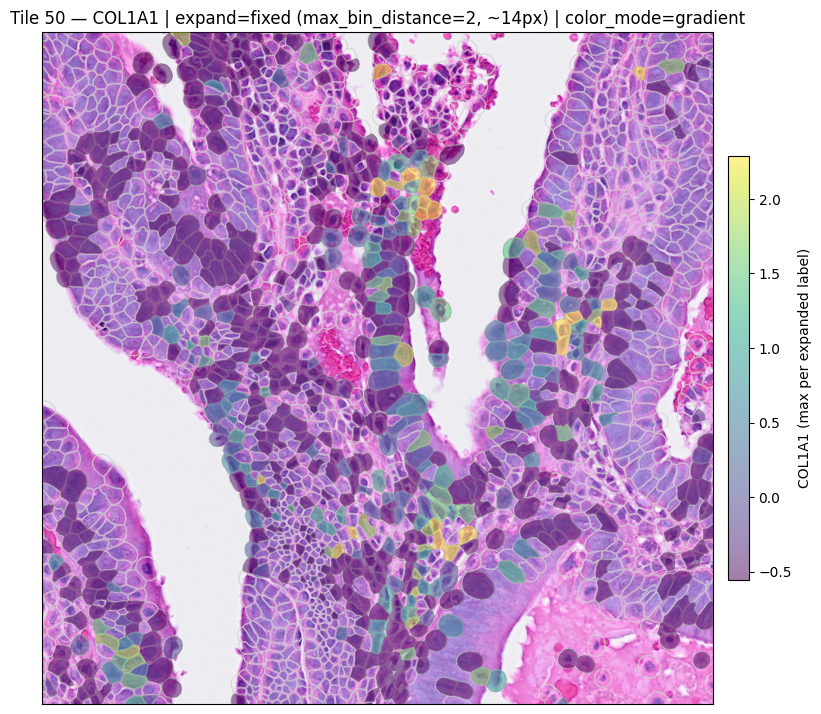

In [38]:
tiles = make_tiles(ctx, tile_h=1500, tile_w=1500)
tile = tiles[50]  

tile_gene_b2c_expand(
    ctx, tile, gene="COL1A1",
    color_mode="gradient",        # or binary
    expr_quantile=None,           # keep all with any mapped centroids
    render_mode="fill",        # or fill
    b2c_mode="fixed",             # fixed is the classic Bin2Cell max_bin_distance expansion
    max_bin_distance=2,           # try 2–4 like in the notebooks
    mpp=0.3,                      # match the mpp used to build the H&E/labels image
    bin_um=2.0,                   # Visium HD bin is ~2 µm
    show_centroids=False,
    all_nuclei_outline=False, # True or false outlines all nuclei

)


/tmp/ipykernel_2225952/3340270406.py:194: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


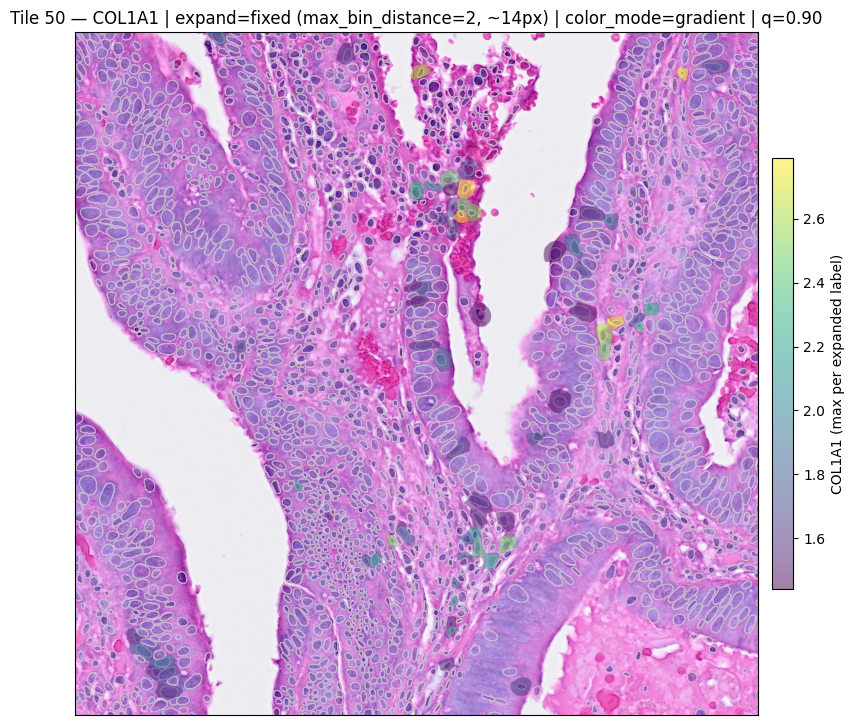

In [36]:
tile_gene_b2c_expand(
    ctx, tile, "COL1A1",
     expr_quantile=0.9,     
    top_n = 100,
    b2c_mode="fixed", max_bin_distance=2,
    color_mode="gradient", render_mode="fill",
    all_expanded_outline=False,            # gray mesh of expanded cells
    all_nuclei_outline=True,             # hide raw nuclei me
)

/tmp/ipykernel_2225952/3340270406.py:194: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


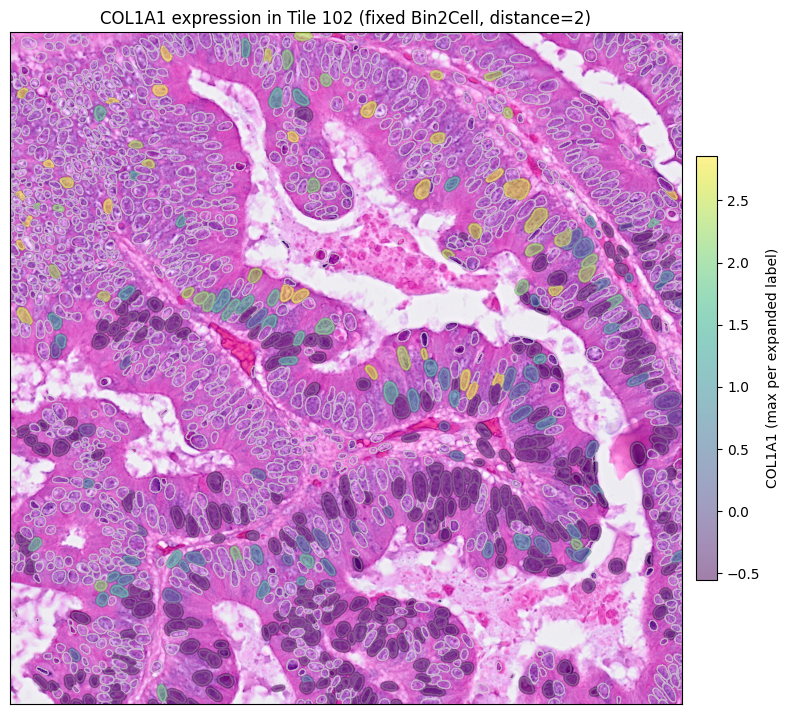

In [44]:
tiles = make_tiles(ctx, tile_h=1500, tile_w=1500)
tile = tiles[132]  

tile_gene_b2c_expand(
    ctx, tile, gene="COL1A1",
    custom_title="COL1A1 expression in Tile 102 (fixed Bin2Cell, distance=2)",
    color_mode="gradient",        # or binary
    expr_quantile=None,           # keep all with any mapped centroids
    render_mode="fill",        # or fill
    b2c_mode="fixed",             # fixed is the classic Bin2Cell max_bin_distance expansion
    max_bin_distance=0.5,           # try 2–4 like in the notebooks
    mpp=0.3,                      # match the mpp used to build the H&E/labels image
    bin_um=2.0,                   # Visium HD bin is ~2 µm
    show_centroids=True,
    all_nuclei_outline=True, # True or false outlines all nuclei
    all_expanded_outline=False,            # gray mesh of expanded cells


)


/tmp/ipykernel_2225952/3340270406.py:194: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


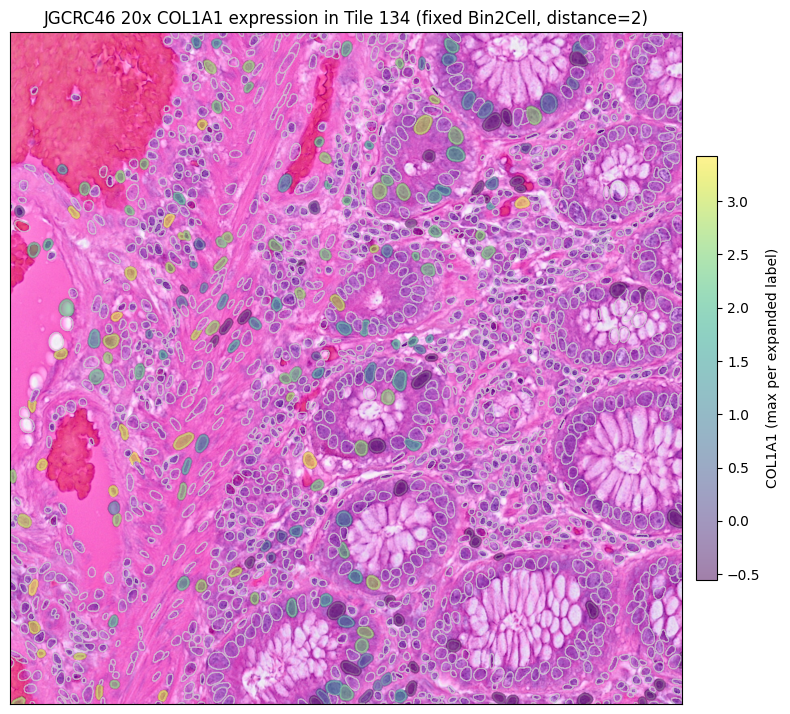

In [54]:
tiles = make_tiles(ctx, tile_h=1500, tile_w=1500)
tile = tiles[136]  

tile_gene_b2c_expand(
    ctx, tile, gene="COL1A1",
    custom_title="JGCRC46 20x COL1A1 expression in Tile 134 (fixed Bin2Cell, distance=2)",
    color_mode="gradient",        # or binary
    expr_quantile=None,           # keep all with any mapped centroids
    render_mode="fill",        # or fill
    b2c_mode="fixed",             # fixed is the classic Bin2Cell max_bin_distance expansion
    max_bin_distance=0.5,           # try 2–4 like in the notebooks
    mpp=0.3,                      # match the mpp used to build the H&E/labels image
    bin_um=2.0,                   # Visium HD bin is ~2 µm
    show_centroids=True,
    all_nuclei_outline=True, # True or false outlines all nuclei
    all_expanded_outline=False,            # gray mesh of expanded cells



)
